In [4]:
using BenchmarkTools: @btime

In [ ]:
@btime 

In [3]:
println("hei")

hei


In [1]:
using BenchmarkTools: @btime
import LinearAlgebra as la
import Plots as plt

## The pairing states

In [1]:
struct Pairing_State
    p::Int64
    s_z::Int64
    g::Float64
end

function Pairing_State(label, n, l, g)
    if label%2 != 0
        s_z = 1
        p = (label-1) / 2 + 1
    else
        s_z = -1
        p = (label-2) / 2 + 1
    end

    return Pairing_State(p, s_z, g)
end

Pairing_State

In [ ]:
function Ĥ₀(ham::DderHam, p::T, q::T) where T <: Gauss_Funcs
    """
    The one body part of the hamiltonian
    
    delta = 1
    """
    if p == q # if p and q are the same state
        return p.p - 1
    else
        return 0.0
    end
end

In [3]:
function Ĥ₀(p::T, q::T) where T <: Pairing_State
    """
    The one body part of the hamiltonian
    
    delta = 1
    """
    if p == q # if p and q are the same state
        return p.p - 1
    else
        return 0.0
    end
end

Ĥ₀ (generic function with 1 method)

In [4]:
function V̂(p::T, q::T, r::T, s::T) where T <: Pairing_State
    g = p.g
    p1, s1 = p.p, p.s_z
    p2, s2 = q.p, q.s_z
    p3, s3 = r.p, r.s_z
    p4, s4 = s.p, s.s_z

    if p1 != p2 || p3 != p4
        return 0.0
    end
    if s1 == s2 || s3 == s4
        return 0.0
    end
    if s1 == s3 && s2 == s4
        return -g/2
    end
    if s1 == s4 && s2 == s3
        return g/2
    end
end

V̂ (generic function with 1 method)

## CCD

In [48]:
struct CCD_System
    n::Int64
    l::Int64
    
    h::Matrix{Float64}
    u::Array{Float64, 4}
    ϵ::Vector{Float64}
    
    t::Array{Float64, 4}
    t_new::Array{Float64, 4}
    α::Float64
end

function CCD_System(n, l, α, states::Vector{Pairing_State})
    h = zeros((l, l))
    u = zeros((l, l, l, l))

    for p in 1:l
        for q in 1:l
            h[p, q] = Ĥ₀(states[p], states[q])

            for r in 1:l
                for s in 1:l
                    u[p, q, r, s] = V̂(states[p], states[q], states[r], states[s])
                end
            end
        end
    end

    ϵ = zeros(l)
    for q in 1:l
        ϵ[q] = h[q, q]
        for i in 1:n
            ϵ[q] += u[q, i, q, i]
        end
    end
    
    t = zeros((l, l, l, l))
    t_new = zeros((l, l, l, l))
    
    for i in 1:n
        for j in 1:n
            for a in n+1:l
                for b in n+1:l
                    t[a, b, i, j] = u[a, b, i, j] / (ϵ[i] + ϵ[j] - ϵ[a] - ϵ[b])
                end
            end
        end
    end
    
    return CCD_System(n, l, h, u, ϵ, t, t_new, α)
end

CCD_System

In [49]:
function E_CCD(system)
    n, l, u, t = system.n, system.l, system.u, system.t
    E = 0.0
    for i in 1:n
        for j in 1:n
            for a in n+1:l
                for b in n+1:l
                    E += u[i, j, a, b] * t[a, b, i, j]
                end
            end
        end
    end
    return 0.25 * E
end

E_CCD (generic function with 1 method)

In [50]:
function CCD_Update!(system)
    n, l, u, ϵ, t, t_new, α = system.n, system.l, system.u, system.ϵ, system.t, system.t_new, system.α
    
    for i in 1:n
        for j in i+1:n
            for a in n+1:l
                for b in a+1:l
                    # Page 361 of An Advanced Course in Computational Physics
                    s = 0

                    s += u[a, b, i, j]

                    for c in n+1:l
                        for d in n+1:l
                            s += 0.5 * u[a, b, c, d] * t[c, d, i, j]
                        end
                    end

                    for k in 1:n
                        for li in 1:n
                            s += 0.5 * u[k, li, i, j] * t[a, b, k, li]
                        end
                    end

                    for k in 1:n
                        for c in n+1:l
                            s += u[k, b, c, j] * t[a, c, i, k] # 1
                            s -= u[k, b, c, i] * t[a, c, j, k] # -Pij
                            s -= u[k, a, c, j] * t[b, c, i, k] # -Pab
                            s += u[k, a, c, i] * t[b, c, j, k] # Pij Pab
                        end
                    end

                    for k in 1:n
                        for li in 1:n
                            for c in n+1:l
                                for d in n+1:l
                                    s += 0.25 * u[k, li, c, d] * t[c, d, i, j] * t[a, b, k, li]

                                    s += u[k, li, c, d] * t[a, c, i, k] * t[b, d, j, li] # 1
                                    s -= u[k, li, c, d] * t[a, c, j, k] * t[b, d, i, li] # -Pij

                                    s -= 0.5 * u[k, li, c, d] * t[d, c, i, k] * t[a, b, li, j] # -1
                                    s += 0.5 * u[k, li, c, d] * t[d, c, j, k] * t[a, b, li, i] # Pij

                                    s -= 0.5 * u[k, li, c, d] * t[a, c, li, k] * t[d, b, i, j] # -1
                                    s += 0.5 * u[k, li, c, d] * t[b, c, li, k] * t[d, a, i, j] # Pab
                                end
                            end
                        end
                    end

                    ϵ_abij = ϵ[i] + ϵ[j] - ϵ[a] - ϵ[b]
                    s = α * t[a, b, i, j] + (1 - α) * s / ϵ_abij
                    t_new[a, b, i, j] = s
                    t_new[a, b, j, i] = -s
                    t_new[b, a, i, j] = -s
                    t_new[b, a, j, i] = s
                end
            end
        end
    end
    t .= t_new
    return system
end

CCD_Update! (generic function with 1 method)

## CCSD

In [61]:
struct CCSD_System
    n::Int64
    l::Int64
    
    h::Matrix{Float64}
    u::Array{Float64, 4}
    ϵ::Vector{Float64}
    
    t1::Matrix{Float64}
    t1_new::Matrix{Float64}
    
    t2::Array{Float64, 4}
    t2_new::Array{Float64, 4}
    α::Float64
end

function CCSD_System(n, l, α, states::Vector{Pairing_State})
    h = zeros((l, l))
    u = zeros((l, l, l, l))

    for p in 1:l
        for q in 1:l
            h[p, q] = Ĥ₀(states[p], states[q])

            for r in 1:l
                for s in 1:l
                    u[p, q, r, s] = V̂(states[p], states[q], states[r], states[s])
                end
            end
        end
    end

    ϵ = zeros(l)
    for q in 1:l
        ϵ[q] = h[q, q]
        for i in 1:n
            ϵ[q] += u[q, i, q, i]
        end
    end
    
    t1 = zeros((l, l))
    t1_new = zeros((l, l))
    
    for i in 1:n
        for a in n+1:l
            t1[a, i] = h[a, i] / (ϵ[i] - ϵ[a])
        end
    end
    
    t2 = zeros((l, l, l, l))
    t2_new = zeros((l, l, l, l))
    
    for i in 1:n
        for j in 1:n
            for a in n+1:l
                for b in n+1:l
                    t2[a, b, i, j] = u[a, b, i, j] / (ϵ[i] + ϵ[j] - ϵ[a] - ϵ[b])
                end
            end
        end
    end
    
    return CCSD_System(n, l, h, u, ϵ, t1, t1_new, t2, t2_new, α)
end

CCSD_System

In [54]:
function E_CCSD(system)
    n, l, h, u, t1, t2 = system.n, system.l, system.h, system.u, system.t1, system.t2
    
    E = 0.0
    
    for i in 1:n
        for a in n+1:l
            E += h[i, a] * t1[a, i]
        end
    end
    
    for i in 1:n
        for j in 1:n
            for a in n+1:l
                for b in n+1:l
                    E += 0.25 * u[i, j, a, b] * t2[a, b, i, j]
                    E += 0.5 * u[i, j, a, b] * t1[a, i] * t1[b, j]
                end
            end
        end
    end
    
    return E
end

E_CCSD (generic function with 1 method)

In [72]:
function CCSD_Update!(system)
    n, L, h, u, ϵ, α = system.n, system.l, system.h, system.u, system.ϵ, system.α
    t1, t1_new, t2, t2_new = system.t1, system.t1_new, system.t2, system.t2_new
    
    """
    The t1 amplitude equations, from page 75 of Crawford & Schaefer
    """
    for i in 1:n
        for a in n+1:L
            x = 0.0

            x += h[a, i]

            # Terms that were moved over
            x -= h[a, a] * t1[a, i]
            x += h[i, i] * t1[a, i]

            for c in n+1:L
                x += h[a, c] * t1[c, i]
            end

            for k in 1:n
                x -= h[k, i] * t1[a, k]
            end

            for k in 1:n
                for c in n+1:L
                    x += u[k, a, c, i] * t1[c, k]

                    x += h[k, c] * t2[a, c, i, k]

                    x -= h[k, c] * t1[c, i] * t1[a, k]
                end
            end

            for k in 1:n
                for c in n+1:L
                    for d in n+1:L
                        x += 0.5 * u[k, a, c, d] * t2[c, d, k, i]

                        x -= u[k, a, c, d] * t1[c, k] * t1[d, i]
                    end
                end
            end

            for k in 1:n
                for l in 1:n
                    for c in n+1:L
                        x -= 0.5 * u[k, l, c, i] * t2[c, a, k, l]

                        x -= u[k, l, c, i] * t1[c, k] * t1[a, l]
                    end
                end
            end

            for k in 1:n
                for l in 1:n
                    for c in n+1:L
                        for d in n+1:L
                            x -= u[k, l, c, d] * t1[c, k] * t1[d, i] * t1[a, l]

                            x += u[k, l, c, d] * t1[c, k] * t2[d, a, l, i]

                            x -= 0.5 * u[k, l, c, d] * t2[c, d, k, i] * t1[a, l]

                            x -= 0.5 * u[k, l, c, d] * t2[c, a, k, l] * t1[d, i]
                        end
                    end
                end
            end

            ϵ_ai = ϵ[i] - ϵ[a]
            x = α * t1[a, i] + (1 - α) * x / ϵ_ai
            t1_new[a, i] = x
        end
    end
    
    """
    The t2 amplitude equations, from page 76 of Crawford & Schaefer
    """
    for i in 1:n
        for j in i+1:n
            for a in n+1:L
                for b in a+1:L
                    s = 0.0

                    s += u[a, b, i, j]
                    
                    # Terms that were moved over
                    s -= h[b, b] * t2[a, b, i, j] # -δbc
                    s += h[a, a] * t2[b, a, i, j] # Pab δbc
                    s += h[j, j] * t2[a, b, i, j] # δkj
                    s -= h[i, i] * t2[a, b, j, i] # -Pij δkj

                    for c in n+1:L
                        s += h[b, c] * t2[a, c, i, j] # 1
                        s -= h[a, c] * t2[b, c, i, j] # -Pab
                        
                        s += u[a, b, c, j] * t1[c, i] # 1
                        s -= u[a, b, c, i] * t1[c, j] # -Pij
                    end
                    
                    for k in 1:n
                        s -= h[k, j] * t2[a, b, i, k] # -1
                        s += h[k, i] * t2[a, b, j, k] # Pij
                        
                        s -= u[k, b, i, j] * t1[a, k] # -1
                        s += u[k, a, i, j] * t1[b, k] # Pab
                    end
                    
                    for k in 1:n
                        for l in 1:n
                            s += 0.5 * u[k, l, i, j] * t2[a, b, k, l]
                            
                            s += 0.5 * u[k, l, i, j] * t1[a, k] * t1[b, l] # 1
                            s -= 0.5 * u[k, l, i, j] * t1[b, k] * t1[a, l] # -Pab
                        end
                    end
                    
                    for c in n+1:L
                        for d in n+1:L
                            s += 0.5 * u[a, b, c, d] * t2[c, d, i, j]
                            
                            s += 0.5 * u[a, b, c, d] * t1[c, i] * t1[d, j] # 1
                            s -= 0.5 * u[a, b, c, d] * t1[c, j] * t1[d, i] # -Pij
                        end
                    end
                    
                    for k in 1:n
                        for c in n+1:L
                            s += u[k, b, c, j] * t2[a, c, i, k] # 1
                            s -= u[k, b, c, i] * t2[a, c, j, k] # -Pij
                            s -= u[k, a, c, j] * t2[b, c, i, k] # -Pab
                            s += u[k, a, c, i] * t2[b, c, j, k] # Pij Pab
                            
                            s -= u[k, b, i, c] * t1[a, k] * t1[c, j] # -1
                            s += u[k, b, j, c] * t1[a, k] * t1[c, i] # Pij
                            s += u[k, a, i, c] * t1[b, k] * t1[c, j] # Pab
                            s -= u[k, a, j, c] * t1[b, k] * t1[c, i] # -Pij Pab
                            
                            s += h[k, c] * t1[a, k] * t2[b, c, i, j] # 1
                            s -= h[k, c] * t1[b, k] * t2[a, c, i, j] # -Pab
                            
                            s += h[k, c] * t1[c, i] * t2[a, b, j, k] # 1
                            s -= h[k, c] * t1[c, j] * t2[a, b, i, k] # -Pij
                        end
                    end
                    
                    for k in 1:n
                        for l in 1:n
                            for c in n+1:L
                                s -= u[k, l, c, i] * t1[c, k] * t2[a, b, l, j] # -1
                                s += u[k, l, c, j] * t1[c, k] * t2[a, b, l, i] # Pij
                                
                                s += u[k, l, i, c] * t1[a, l] * t2[b, c, j, k] # 1
                                s -= u[k, l, j, c] * t1[a, l] * t2[b, c, i, k] # -Pij
                                s -= u[k, l, i, c] * t1[b, l] * t2[a, c, j, k] # -Pab
                                s += u[k, l, j, c] * t1[b, l] * t2[a, c, i, k] # Pij Pab
                                
                                s += 0.5 * u[k, l, c, j] * t1[c, i] * t2[a, b, k, l] # 1
                                s -= 0.5 * u[k, l, c, i] * t1[c, j] * t2[a, b, k, l] # -Pij
                                
                                s += 0.5 * u[k, l, c, j] * t1[c, i] * t1[a, k] * t1[b, l] # 1
                                s -= 0.5 * u[k, l, c, i] * t1[c, j] * t1[a, k] * t1[b, l] # -Pij
                                s -= 0.5 * u[k, l, c, j] * t1[c, i] * t1[b, k] * t1[a, l] # -Pab
                                s += 0.5 * u[k, l, c, i] * t1[c, j] * t1[b, k] * t1[a, l] # Pij Pab
                            end
                        end
                    end
                    
                    for k in 1:n
                        for c in n+1:L
                            for d in n+1:L
                                s += u[k, a, c, d] * t1[c, k] * t2[d, b, i, j] # 1
                                s -= u[k, b, c, d] * t1[c, k] * t2[d, a, i, j] # -Pab
                                
                                s += u[a, k, d, c] * t1[d, i] * t2[b, c, j, k] # 1
                                s -= u[a, k, d, c] * t1[d, j] * t2[b, c, i, k] # -Pij
                                s -= u[b, k, d, c] * t1[d, i] * t2[a, c, j, k] # -Pab
                                s += u[b, k, d, c] * t1[d, j] * t2[a, c, i, k] # Pij Pab
                                
                                s -= 0.5 * u[k, b, c, d] * t1[a, k] * t2[c, d, i, j] # -1
                                s += 0.5 * u[k, a, c, d] * t1[b, k] * t2[c, d, i, j] # Pab
                                
                                s -= u[k, b, c, d] * t1[c, i] * t1[a, k] * t1[d, j] # -1
                                s += u[k, b, c, d] * t1[c, j] * t1[a, k] * t1[d, i] # Pij
                                s += u[k, a, c, d] * t1[c, i] * t1[b, k] * t1[d, j] # Pab
                                s -= u[k, a, c, d] * t1[c, j] * t1[b, k] * t1[d, i] # -Pij Pab
                            end
                        end
                    end
                    
                    for k in 1:n
                        for l in 1:n
                            for c in n+1:L
                                for d in n+1:L
                                    s += 0.5 * u[k, l, c, d] * t2[a, c, i, k] * t2[d, b, l, j] # 1
                                    s -= 0.5 * u[k, l, c, d] * t2[a, c, j, k] * t2[d, b, l, i] # -Pij
                                    s -= 0.5 * u[k, l, c, d] * t2[b, c, i, k] * t2[d, a, l, j] # -Pab
                                    s += 0.5 * u[k, l, c, d] * t2[b, c, j, k] * t2[d, a, l, i] # Pij Pab
                                    
                                    s += 0.25 * u[k, l, c, d] * t2[c, d, i, j] * t2[a, b, k, l]

                                    s -= 0.5 * u[k, l, c, d] * t2[a, c, i, j] * t2[b, d, k, l] # -1
                                    s += 0.5 * u[k, l, c, d] * t2[b, c, i, j] * t2[a, d, k, l] # Pab
                                    
                                    s -= 0.5 * u[k, l, c, d] * t2[a, b, i, k] * t2[c, d, j, l] # -1
                                    s += 0.5 * u[k, l, c, d] * t2[a, b, j, k] * t2[c, d, i, l] # Pij
                                    
                                    s -= u[k, l, c, d] * t1[c, k] * t1[d, i] * t2[a, b, l, j] # -1
                                    s += u[k, l, c, d] * t1[c, k] * t1[d, j] * t2[a, b, l, i] # Pij
                                    
                                    s -= u[k, l, c, d] * t1[c, k] * t1[a, l] * t2[d, b, i, j] # -1
                                    s += u[k, l, c, d] * t1[c, k] * t1[b, l] * t2[d, a, i, j] # Pab
                                    
                                    s += 0.25 * u[k, l, c, d] * t1[c, i] * t1[d, j] * t2[a, b, k, l] # 1
                                    s -= 0.25 * u[k, l, c, d] * t1[c, j] * t1[d, i] * t2[a, b, k, l] # -Pij
                                    
                                    s += 0.25 * u[k, l, c, d] * t1[a, k] * t1[b, l] * t2[c, d, i, j] # 1
                                    s -= 0.25 * u[k, l, c, d] * t1[b, k] * t1[a, l] * t2[c, d, i, j] # -Pab
                                    
                                    s += u[k, l, c, d] * t1[c, i] * t1[b, l] * t2[a, d, k, j] # 1
                                    s -= u[k, l, c, d] * t1[c, j] * t1[b, l] * t2[a, d, k, i] # -Pij
                                    s -= u[k, l, c, d] * t1[c, i] * t1[a, l] * t2[b, d, k, j] # -Pab
                                    s += u[k, l, c, d] * t1[c, j] * t1[a, l] * t2[b, d, k, i] # Pij Pab
                                    
                                    s += 0.25 * u[k, l, c, d] * t1[c, i] * t1[a, k] * t1[d, j] * t1[b, l] # 1
                                    s -= 0.25 * u[k, l, c, d] * t1[c, j] * t1[a, k] * t1[d, i] * t1[b, l] # -Pij
                                    s -= 0.25 * u[k, l, c, d] * t1[c, i] * t1[b, k] * t1[d, j] * t1[a, l] # -Pab
                                    s += 0.25 * u[k, l, c, d] * t1[c, j] * t1[b, k] * t1[d, i] * t1[a, l] # Pij Pab
                                end
                            end
                        end
                    end
                    
                    ϵ_abij = ϵ[i] + ϵ[j] - ϵ[a] - ϵ[b]
                    s = α * t2[a, b, i, j] + (1 - α) * s / ϵ_abij
                    t2_new[a, b, i, j] = s
                    t2_new[a, b, j, i] = -s
                    t2_new[b, a, i, j] = -s
                    t2_new[b, a, j, i] = s
                end
            end
        end
    end
    
    t1 .= t1_new
    t2 .= t2_new
    
    return system
end

CCSD_Update! (generic function with 1 method)

## Other methods

In [8]:
function MBPT2(g)
    return -g^2 / 4 * ( 1 / (4+g) + 1/(6+g) + 1/(2+g) + 1/(4+g) )
end

MBPT2 (generic function with 1 method)

In [9]:
function exact(g)
    H = [ 2-g  -g/2 -g/2 -g/2 -g/2  0
         -g/2  4-g  -g/2 -g/2  0   -g/2
         -g/2 -g/2   6-g  0   -g/2 -g/2
         -g/2 -g/2   0    6-g -g/2 -g/2
         -g/2  0    -g/2 -g/2  8-g -g/2
          0   -g/2  -g/2 -g/2 -g/2  10-g]
    return la.eigvals(H)[1] - (2 - g)
end

exact (generic function with 1 method)

## Testing it out

In [96]:
n = 4
l = 8
g = 0.1
α = 0.5

states = [Pairing_State(label, n, l, g) for label in 1:l];
system = CCD_System(n, l, α, states);

In [106]:
CCD_Update!(system);

In [12]:
E_CCD(system)

-0.0029046040188602826

In [108]:
n = 4
l = 8
g = 0.1
α = 0.5

states = [Pairing_State(label, n, l, g) for label in 1:l];
system = CCSD_System(n, l, α, states);

In [109]:
CCSD_Update!(system);

  0.000360 seconds


In [92]:
E_CCSD(system)

-0.00298613916931443

In [151]:
function CCD_run(g)
    n = 4
    l = 8
    α = 0.5

    states = [Pairing_State(label, n, l, g) for label in 1:l]
    system = CCD_System(n, l, α, states)
    for i in 1:10
        CCD_Update!(system)
    end
    return E_CCD(system)
end

CCD_run (generic function with 1 method)

In [152]:
function CCSD_run(g)
    n = 4
    l = 8
    α = 0.5

    states = [Pairing_State(label, n, l, g) for label in 1:l]
    system = CCSD_System(n, l, α, states)
    for i in 1:10
        CCSD_Update!(system)
    end
    return E_CCSD(system)
end

CCSD_run (generic function with 1 method)

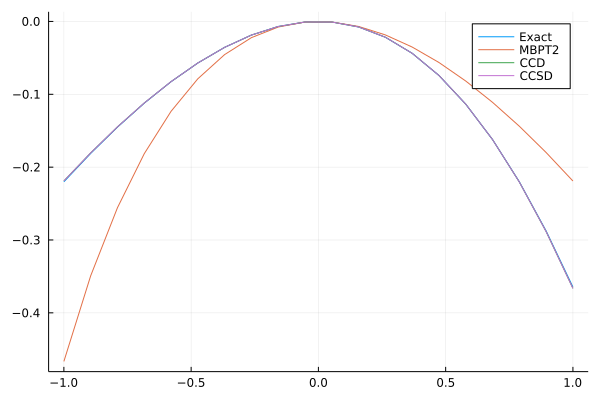

In [153]:
g_range = range(-1, 1, length = 20)

plt.plot(g_range, exact.(g_range), lw = 1, label = "Exact")
plt.plot!(g_range, MBPT2.(g_range), lw = 1, label = "MBPT2")
plt.plot!(g_range, CCD_run.(g_range), lw = 1, label = "CCD")
plt.plot!(g_range, CCSD_run.(g_range), lw = 1, label = "CCSD")

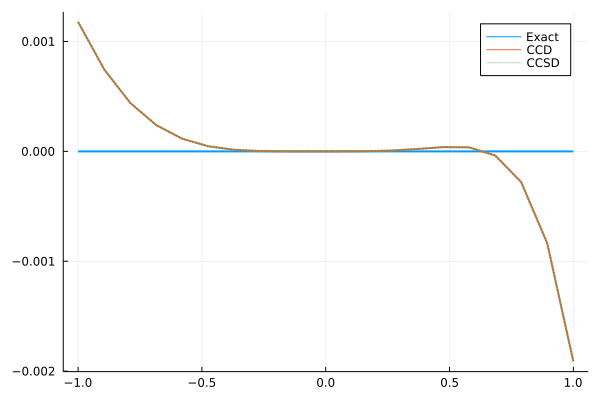

In [156]:
g_range = range(-1, 1, length = 20)

ex = exact.(g_range)

plt.plot(g_range, ex .- ex, lw = 2, label = "Exact")
plt.plot!(g_range, CCD_run.(g_range) .- ex, lw = 2, label = "CCD")
plt.plot!(g_range, CCSD_run.(g_range) .- ex, lw = 2, ls = :dot, label = "CCSD")